In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cclib.parser import QChem  # needs maxscheurer/cclib dev-qchem branch!
import itertools
from scipy import constants
eV = constants.value("Hartree energy in eV")

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def triangle_to_mat(y):
    mat = np.empty((3, 3))
    mat[0, 0] = y[0]
    mat[0, 1] = mat[1, 0] = y[1]
    mat[0, 2] = mat[2, 0] = y[2]
    mat[1, 1] = y[3]
    mat[1, 2] = mat[2, 1] = y[4]
    mat[2, 2] = y[5]
    return mat


# read the polarizability tensors from CCSD calculations in Q-Chem
def read_pol(outfile):
    with open(outfile, "r") as tmp:
        lines = tmp.readlines()

    lines = [l.strip() for l in lines]

    pols = []

    for i, l in enumerate(lines):
        if "Polarizability Tensor" in l:
            pol_str = "\n".join(lines[i+2:i+5])
            pol = np.fromstring(pol_str, sep=" ").reshape(3, 3)
            pols.append(pol)

    # xx, xy, xz, yy, yz, zz
    components = list(itertools.combinations_with_replacement([0, 1, 2], r=2))
    response = np.zeros((len(pols), len(components)))

    for i, p in enumerate(pols):
        response[i] = [p[c] for c in components]
        atol = np.max(np.abs(p - p.T))
#         print(atol)
#         assert atol < 1e-4
        np.testing.assert_allclose(triangle_to_mat(response[i]), p, atol=atol)

    comps = ['x', 'y', 'z']
    comps_str = ["a_" + comps[c[0]] + comps[c[1]] for c in components]
    df = pd.DataFrame(data=response, columns=comps_str)
    df['a_iso'] = 1.0 / 3.0 * (df["a_xx"] + df["a_yy"] + df["a_zz"])
    return df


# remove irreps not in irreps_wanted from DataFrame
def drop_irreps(df, irreps_wanted):
    irreps_in_df = df.irrep.unique()
    for irr in irreps_in_df:
        if irr not in irreps_wanted:
            indexNames = df[df['irrep'] == irr].index
            df.drop(indexNames, inplace=True)

## Definitions of all jobs/molecules

In [3]:
jobs = {
     "s-tetrazine": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "stetrazine",
         "qchem_name": "stetrazine_gs",
         "irreps_wanted": ['X'],
         "state_limit": 1,
     },
     "s-tetrazine-exc": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "stetrazine",
         "qchem_name": "stetrazine_b13u",
         "irreps_wanted": ['B1u'],
         "state_limit": 1,
     },
     "pyrimidine": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "pyrimidine",
         "qchem_name": "pyrimidine",
         "irreps_wanted": ['X', 'B2'],
         "state_limit": 2,
     },
     "uracil": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "uracil",
         "qchem_name": "uracil",
         "irreps_wanted": ['X', 'A"', "A'"],
         "state_limit": 2,
     },
     "pna": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "pna",
         "qchem_name": "pna",
         "irreps_wanted": ["X", "A1"],
         "state_limit": 1,
     }
}

nice_labels = {
    "a_xx": r"$\alpha_{xx}$",
    "a_yy": r"$\alpha_{yy}$",
    "a_zz": r"$\alpha_{zz}$",
    "a_iso": r"$\alpha_\text{iso}$",
    "etenergies": r"$E_\text{exc}$",
    "adc2": "ADC(2)",
    "adc2x": "ADC(2)-x",
    "adc3": "ADC(3)",
    "ccsd_der": "CCSD Der.",
    "ccsd_ev": "CCSD E.V.",
}

## Generate summary tables for each molecule

In [4]:
dfcs = []
for j in jobs.keys():
    print(j)
    job = jobs[j]
    system_name = j
    qchem_name = job["qchem_name"]
    qchem_folder = job["qchem_folder"]
    irreps_wanted = job["irreps_wanted"]
    state_limit = job["state_limit"]
    all_dfs = []
    
    d_eom_ev = QChem(f"ccsd/{qchem_folder}/{qchem_name}_eompol4.out").parse()
    alphas_ev = read_pol(f"ccsd/{qchem_folder}/{qchem_name}_eompol4.out")
    alphas_ev["system"] = system_name
    alphas_ev["method"] = "ccsd_ev"
    alphas_ev["etenergies"] = 0.0
    alphas_ev["irrep"] = "X"
    for i, ee in enumerate(d_eom_ev.etenergies, 1):
        alphas_ev.etenergies.values[i] = ee
        alphas_ev.irrep.values[i] = d_eom_ev.etirreps[i-1]
    drop_irreps(alphas_ev, irreps_wanted)
    alphas_ev.sort_values(by=["etenergies"], inplace=True)
    alphas_ev["state"] = range(len(alphas_ev.etenergies + 1))
        
    d_eom_der = QChem(f"ccsd/{qchem_folder}/{qchem_name}_eompol2.out").parse()
    alphas_der = read_pol(f"ccsd/{qchem_folder}/{qchem_name}_eompol2.out")
    alphas_der["system"] = system_name
    alphas_der["method"] = "ccsd_der"
    alphas_der["etenergies"] = 0.0
    alphas_der["irrep"] = "X"
    for i, ee in enumerate(d_eom_der.etenergies, 1):
        alphas_der.etenergies.values[i] = ee
        alphas_der.irrep.values[i] = d_eom_der.etirreps[i-1]
    drop_irreps(alphas_der, irreps_wanted)
    alphas_der.sort_values("etenergies", inplace=True)
    alphas_der["state"] = range(len(alphas_der.etenergies + 1))
        
    # loop over ADC methods
    dfs_adc = []
    for method in job["adc_methods"]:
        df_adcc = pd.read_pickle(f"results/{system_name}-{method}.pkl")
        df_adcc["system"] = system_name
        df_adcc["method"] = method
        df_adcc["etenergies"] = df_adcc["ee"] * eV
        df_adcc.drop(columns=["ee"], inplace=True)
                
        d_adc = QChem(f"ccsd/{qchem_folder}/{qchem_name}_{method}.out").parse()
        
        # determine the irrep of the adcc excited state from Q-Chem results
        df_adcc["irrep"] = "NN"
        for ia, ee in enumerate(df_adcc.etenergies.values):
            if np.isnan(ee):
                df_adcc.irrep.values[ia] = "X"
                df_adcc.etenergies.values[ia] = 0.0
                continue
            for ii, ee_qc in enumerate(d_adc.etenergies):
                if np.abs(ee-ee_qc) < 1e-4:
                    irrep = d_adc.etirreps[ii]
                    df_adcc.irrep.values[ia] = irrep
        # delete cells with unassignable irrep
        drop_irreps(df_adcc, irreps_wanted)
        df_adcc["state"] = range(len(df_adcc.etenergies + 1))
        
        dfs_adc.append(df_adcc)
    
    all_dfs.extend(dfs_adc)
    all_dfs.extend([alphas_ev, alphas_der])
    df = pd.concat(all_dfs, sort=False, ignore_index=True)

    # remove off-diagonal components, not subject to discussion
    dfc = df.drop(columns=[
        "a_xy", "a_xz", "a_yz",
    ])
    dfc = dfc.query(f'state <= {state_limit}')
    dfcs.append(dfc)

    irrep_string = ", ".join([f'\"{i}\"' for i in irreps_wanted])
    df = df.query(f'state <= {state_limit}')
    
    order = irreps_wanted
    values = ["a_xx", "a_yy", "a_zz", "etenergies"]
    dfp = pd.pivot_table(df, index=["method"], values=values, columns=["irrep"])

    dfp = dfp.swaplevel(0, 1, axis=1).sort_index(axis=1)
    cols = list(itertools.product(order, values))
    dfp = dfp.reindex(cols, axis=1)
    dfp = dfp.round(2)
    
    new_labels_level1 = [nice_labels.get(label, label) for label in dfp.columns.levels[1].values]
    dfp.columns.set_levels(new_labels_level1, level=1, inplace=True)
    
    new_labels_index = [nice_labels.get(label, label) for label in dfp.index.values]
    dfp.index = new_labels_index
        
    display(dfp)

s-tetrazine


irrep                 X                                           
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $E_\text{exc}$
ADC(2)            66.08         61.26         33.50            0.0
ADC(2)-x          69.38         64.96         35.72            0.0
ADC(3)            64.10         59.57         33.41            0.0
CCSD Der.         60.73         56.02         32.73            0.0
CCSD E.V.         62.82         58.01         33.48            0.0

s-tetrazine-exc


irrep               B1u                                           
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $E_\text{exc}$
ADC(2)            39.06         78.55         15.71           2.20
ADC(2)-x          50.64         80.08         21.60           1.31
ADC(3)            57.28         74.94         25.90           2.18
CCSD Der.         66.03         80.09         31.93           2.39
CCSD E.V.         49.28         71.75         23.05           2.39

pyrimidine


irrep                 X                                             \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $E_\text{exc}$   
ADC(2)            73.48         38.69         76.22            0.0   
ADC(2)-x          77.21         39.99         79.97            0.0   
ADC(3)            71.24         38.27         73.61            0.0   
CCSD Der.         67.79         37.50         70.18            0.0   
CCSD E.V.         70.05         38.25         72.52            0.0   

irrep                B2                                             
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $E_\text{exc}$  
ADC(2)           118.89         26.65         38.79           4.32  
ADC(2)-x         114.28         31.22         51.10           3.44  
ADC(3)           104.45         33.64         57.48           4.50  
CCSD Der.        111.76         42.13         71.38           4.59  
CCSD E.V.        102.93         33.16         51.14           4.59

uracil


irrep                 X                                             \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $E_\text{exc}$   
ADC(2)           105.23         80.00         43.37            0.0   
ADC(2)-x         110.75         83.17         44.48            0.0   
ADC(3)            98.47         76.27         42.30            0.0   
CCSD Der.         95.82         74.62         41.59            0.0   
CCSD E.V.         98.75         76.41         42.42            0.0   

irrep                A"                                             \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $E_\text{exc}$   
ADC(2)            86.44         67.30         27.08           4.73   
ADC(2)-x          85.17         73.16         33.17           3.97   
ADC(3)            74.72         70.74         36.03           5.36   
CCSD Der.         98.08         88.29         45.19           5.22   
CCSD E.V.         71.49         69.43         34.55           5.22   

irrep                A'                                             
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $E_\text{exc}$  
ADC(2)           138.88         81.77         35.46           5.32  
ADC(2)-x         147.08         87.72         38.37           4.61  
ADC(3)           105.12         86.93         42.27           5.38  
CCSD Der.        133.94        102.78         51.69           5.58  
CCSD E.V.        112.82         85.86         42.97           5.58

pna


irrep                 X                                             \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $E_\text{exc}$   
ADC(2)           118.84         58.94        168.68            0.0   
ADC(2)-x         125.29         60.62        183.45            0.0   
ADC(3)           112.76         58.02        162.94            0.0   
CCSD Der.        106.38         56.95        152.90            0.0   
CCSD E.V.        110.76         58.20        157.68            0.0   

irrep                A1                                             
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $E_\text{exc}$  
ADC(2)            68.26         49.52        196.97           4.30  
ADC(2)-x          82.44         50.60        176.49           3.56  
ADC(3)            86.53         59.25        204.37           4.23  
CCSD Der.        109.60         83.60        239.08           4.62  
CCSD E.V.         74.95         69.30        200.89           4.62

## Generate table with mean absolute deviations

In [5]:
dfcs_df = pd.concat(dfcs, sort=False, ignore_index=True)
dfm_full = dfcs_df.melt(id_vars=['system', 'method', 'irrep', 'state'], var_name='property')

dfm_full['state_kind'] = dfm_full.apply(lambda row : "ground_state" if row['irrep'] == "X" else "excited_state", axis=1)

# merge the s-tetrazine results
dfm_full.loc[dfm_full['system'] == "s-tetrazine-exc", 'system'] = 's-tetrazine'

systems = dfm_full.system.unique()
dfs_diff = []
for system in systems:
    dfm = dfm_full.query(f'system == "{system}" and property in ["a_xx", "a_yy", "a_zz"]').copy()
    dfm.sort_values(["method", "state", "property"], inplace=True)

    nrepeats = dfm.method.unique().size

    ref_res = np.tile(dfm.query('method == "ccsd_der"')['value'].values, nrepeats)
    dfm['diff'] = np.abs(dfm['value'].values - ref_res)
    dfm['diff_perc'] = np.abs(dfm['value'].values - ref_res)/ref_res * 100

    dfm.drop(dfm.query('method == "ccsd_der"').index, inplace=True)
    display(system, dfm.groupby(['method', 'state_kind'])['diff'].describe())
    
    dfs_diff.append(dfm)
df_diff_summary = pd.concat(dfs_diff, ignore_index=True)

's-tetrazine'

count       mean        std       min       25%  \
method  state_kind                                                       
adc2    excited_state    3.0  14.908393  12.764773  1.540240  8.878011   
        ground_state     3.0   3.782156   2.615031  0.763276  2.999341   
adc2x   excited_state    3.0   8.577088   7.835645  0.013689  5.171476   
        ground_state     3.0   6.859052   3.357011  2.986393  5.817735   
adc3    excited_state    3.0   6.644517   1.876109  5.151249  5.591604   
        ground_state     3.0   2.532045   1.608047  0.678057  2.024209   
ccsd_ev excited_state    3.0  11.321240   4.703213  8.339908  8.610331   
        ground_state     3.0   1.608649   0.749840  0.744995  1.366101   

                             50%        75%        max  
method  state_kind                                      
adc2    excited_state  16.215782  21.592470  26.969158  
        ground_state    5.235406   5.291596   5.347786  
adc2x   excited_state  10.329264  12.858787  15.388310  
        ground_state    8.649077   8.795382   8.941687  
adc3    excited_state   6.031959   7.391150   8.750341  
        ground_state    3.370361   3.459039   3.547717  
ccsd_ev excited_state   8.880754  12.811906  16.743057  
        ground_state    1.987207   2.040475   2.093743

'pyrimidine'

count       mean        std       min        25%  \
method  state_kind                                                        
adc2    excited_state    3.0  18.397783  12.979673  7.128418  11.301921   
        ground_state     3.0   4.308216   2.705848  1.189909   3.443881   
adc2x   excited_state    3.0  11.238216   8.885359  2.521412   6.715802   
        ground_state     3.0   7.233721   4.112987  2.489294   5.954780   
adc3    excited_state    3.0   9.903917   3.514549  7.312898   7.903663   
        ground_state     3.0   2.552216   1.542857  0.770769   2.099032   
ccsd_ev excited_state    3.0  12.681450   6.554225  8.826721   8.897587   
        ground_state     3.0   1.784420   0.891858  0.755505   1.508414   

                             50%        75%        max  
method  state_kind                                      
adc2    excited_state  15.475423  24.032465  32.589507  
        ground_state    5.697852   5.867370   6.036888  
adc2x   excited_state  10.910192  15.596619  20.283045  
        ground_state    9.420266   9.605935   9.791604  
adc3    excited_state   8.494428  11.199427  13.904426  
        ground_state    3.427295   3.442939   3.458584  
ccsd_ev excited_state   8.968453  14.608814  20.249175  
        ground_state    2.261323   2.298878   2.336433

'uracil'

count       mean       std        min        25%  \
method  state_kind                                                        
adc2    excited_state    6.0  15.483955  6.235078   4.933228  12.785730   
        ground_state     3.0   5.522694  3.815443   1.780833   3.580195   
adc2x   excited_state    6.0  13.596135  1.242728  12.022514  12.968327   
        ground_state     3.0   8.792128  6.025726   2.889407   5.721315   
adc3    excited_state    6.0  17.360959  7.747427   9.157399  11.026903   
        ground_state     3.0   1.671980  0.970284   0.712707   1.181514   
ccsd_ev excited_state    6.0  17.141945  6.652261   8.722984  12.211162   
        ground_state     3.0   1.854225  1.047867   0.837009   1.316204   

                             50%        75%        max  
method  state_kind                                      
adc2    excited_state  17.165915  20.268219  21.010686  
        ground_state    5.379557   7.393624   9.407691  
adc2x   excited_state  13.226659  14.625802  15.126579  
        ground_state    8.553223  11.743488  14.933753  
adc3    excited_state  16.701171  21.910974  28.822960  
        ground_state    1.650321   2.151616   2.652911  
ccsd_ev excited_state  17.888717  20.551896  26.592988  
        ground_state    1.795400   2.362833   2.930265

'pna'

count       mean        std        min        25%  \
method  state_kind                                                         
adc2    excited_state    3.0  39.171556   4.430516  34.075248  37.703691   
        ground_state     3.0  10.077839   7.202378   1.984640   7.225484   
adc2x   excited_state    3.0  40.912979  18.998998  27.152778  30.074371   
        ground_state     3.0  17.709939  13.478388   3.670926  11.291297   
adc3    excited_state    3.0  27.372484   6.382329  23.067417  23.706144   
        ground_state     3.0   5.829036   4.511431   1.066294   3.724535   
ccsd_ev excited_state    3.0  29.042883  12.895598  14.293748  24.469074   
        ground_state     3.0   3.470106   1.936114   1.246331   2.814597   

                             50%        75%        max  
method  state_kind                                      
adc2    excited_state  41.332133  41.719709  42.107285  
        ground_state   12.466328  14.124439  15.782550  
adc2x   excited_state  32.995965  47.793079  62.590194  
        ground_state   18.911667  24.729445  30.547223  
adc3    excited_state  24.344870  29.525018  34.705165  
        ground_state    6.382777   8.210407  10.038036  
ccsd_ev excited_state  34.644400  36.417450  38.190500  
        ground_state    4.382863   4.581994   4.781125

## Generate summary statistics (box plot)

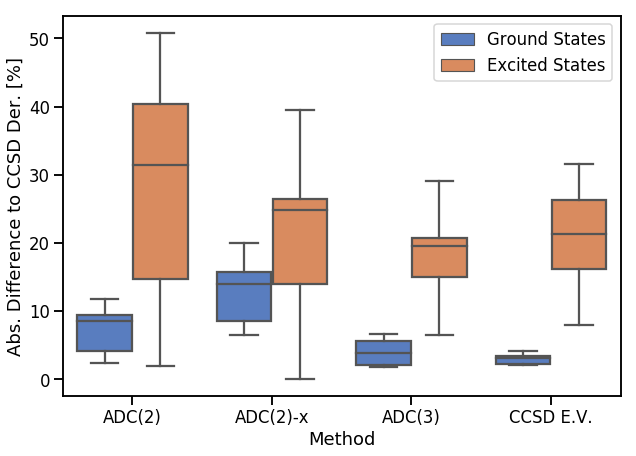

In [6]:
sns.set_context("talk")
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches((10, 7))
ax = sns.boxplot(x="method", y="diff_perc", hue="state_kind", data=df_diff_summary, whis=np.inf, palette="muted")
ax.set_ylabel("Abs. Difference to CCSD Der. [%]")
ax.set_xlabel("Method")
ax.set_xticklabels(["ADC(2)", "ADC(2)-x", "ADC(3)", "CCSD E.V."])

L = ax.legend(title="")

for t, l in zip(L.get_texts(), ["Ground States", "Excited States"]): t.set_text(l)
# ax = sns.swarmplot(x="method", y="diff", hue="state_kind", data=df_diff_summary, color=".2", dodge=True, label="")

plt.savefig("difference_summary_perc.pdf", dpi=600)

## Generate table with C6 dispersion coefficients

In [7]:
values = ["c6"]
dfp_c6 = pd.pivot_table(dfcs_df, index=["system", "irrep"], values=values, columns=["method"])
display(dfp_c6)

c6                          
method                        adc2        adc2x         adc3
system          irrep                                       
pna             A1     2334.708421          NaN          NaN
                X      4396.756604          NaN          NaN
pyrimidine      B2      889.046026  1044.240795  1160.842013
                X      1510.358705  1555.602192  1468.867995
s-tetrazine     X      1161.050358  1197.540012  1129.030249
s-tetrazine-exc B1u     642.847364   795.372863   910.021774
uracil          A"     1099.272240          NaN          NaN
                A'     1355.938320          NaN          NaN
                X      2237.450379          NaN          NaN

In [8]:
fields = ["system", "method", "irrep", "state", "etenergies", "a_xx", "a_yy", "a_zz", "c6", "f", "tdipmom_x", "tdipmom_y", "tdipmom_z", "dipmom_x", "dipmom_y", "dipmom_z"]
dfcs_df = dfcs_df.reindex(fields, axis=1)
dfcs_df = dfcs_df.round(4)
dfcs_df = dfcs_df.fillna('...')
display(dfcs_df)
dfcs_df.to_csv("adc_excipol_results.csv")

,system,method,irrep,state,etenergies,a_xx,a_yy,a_zz,c6,f,tdipmom_x,tdipmom_y,tdipmom_z,dipmom_x,dipmom_y,dipmom_z
0,s-tetrazine,adc2,X,0,0.0000,66.0774,61.2568,33.4974,1161.05,...,...,...,...,0,0,-0
1,s-tetrazine,adc2x,X,0,0.0000,69.3787,64.9631,35.7206,1197.54,...,...,...,...,-0,0,0
2,s-tetrazine,adc3,X,0,0.0000,64.1000,59.5691,33.4122,1129.03,...,...,...,...,-0,0,-0
3,s-tetrazine,ccsd_ev,X,0,0.0000,62.8234,58.0086,33.4792,...,...,...,...,...,...,...,...
4,s-tetrazine,ccsd_der,X,0,0.0000,60.7296,56.0214,32.7342,...,...,...,...,...,...,...,...
5,s-tetrazine-exc,adc2,B1u,0,2.2029,39.0587,78.5485,15.7138,642.847,0.0056,0,0,-0.3231,-0,0,-0
6,s-tetrazine-exc,adc2x,B1u,0,1.3122,50.6395,80.0750,21.6003,795.373,0.0032,0,-0,0.3166,-0,0,-0
7,s-tetrazine-exc,adc3,B1u,0,2.1779,57.2775,74.9375,25.8976,910.022,0.0059,0,-0,-0.3327,-0,0,0
8,s-tetrazine-exc,ccsd_ev,B1u,0,2.3878,49.2848,71.7488,23.0488,...,...,...,...,...,...,...,...
9,s-tetrazine-exc,ccsd_der,B1u,0,2.3878,66.0278,80.0887,31.9296,...,...,...,...,...,...,...,...
